# Chapter 7
## Detection Using Neural Networks

In [1]:
import os, sys
import numpy as np
from math import floor
import pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
from scipy import signal
import multiprocessing as mp


from sklearn import model_selection,preprocessing
# os.environ['THEANO_FLAGS'] = "device=cuda,force_device=True,floatX=float32"
# os.environ["KERAS_BACKEND"] = "theano"
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1,l2, l1_l2
from tensorflow.keras.utils import plot_model, to_categorical



# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from yolo_data_aug import YOLODataAug
from yolo_detector import YOLODetector
from nn_detector import NeuralNetworkDetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)


linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

##  **6.3 Detection with sliding DCNN**

**Load network**

In [2]:
transforms, transforms_params = ['slice', 'zscore','scale'], [[1.5,9.5],None,[0,1]]
cut_params = [1,0.2,8,1.5,2]
name = 'cnn-3conv-2dense-4dropout-100epochs-zscore'

nn = NeuralNetworkDetector(dataset_loc, database_loc, site, transforms, transforms_params)
database = Database(dataset_loc, database_loc, site)

files = database.get_train()
model = nn.load_model(name=name)
scaler = nn.load_scaler(name=name)

### Sliding DCNN

2013-07-19UT04:14:42.00291922.marion.vr2


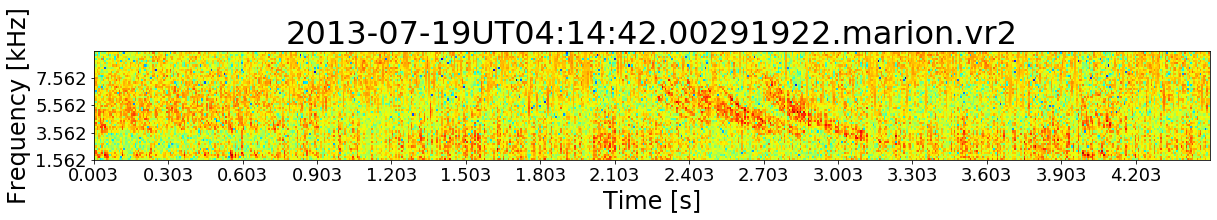

In [48]:
file = np.random.choice(files)
file = '2013-07-19UT04:14:42.00291922.marion.vr2'
# file = '2013-07-07UT16:04:24.27491914.marion.vr2'
# file = '2013-05-18UT13:49:22.14312156.marion.vr2'
print(file)
sample = Sample(dataset_loc, site, file)
freq_size = 4
sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size/2)
sample.apply_transform(transforms, transforms_params)
sample.spectrogram_plot(figsize=sample.get_figsize() , xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                               xaxis=True, yaxis=True,ticks=[0.3,2], title=sample.get_file(), cmap='jet', cmap_show=False, font=font,output=[])
probs = nn.detection_probabilities(file)

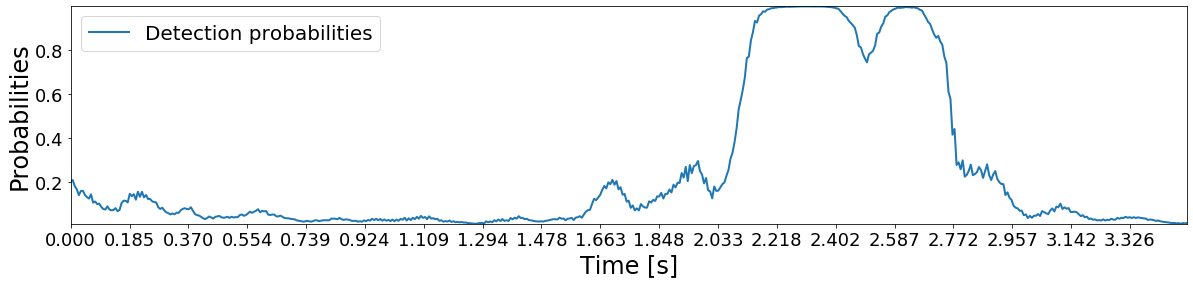

In [4]:
plt.figure(figsize=(sample.get_figsize()[0],4))
plt.plot(list(range(len(probs))*sample.get_time_res()),probs, linewidth=font[-1])
legend = ['Detection probabilities']
plt.xticks(np.linspace(0,len(probs),20)*sample.get_time_res())
plt.autoscale(tight=True)
plt.legend(legend,fontsize=font[1], loc=None)
plt.xlabel('Time [s]',fontsize=font[2])
plt.ylabel('Probabilities',fontsize=font[2])
plt.xticks(fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.show()

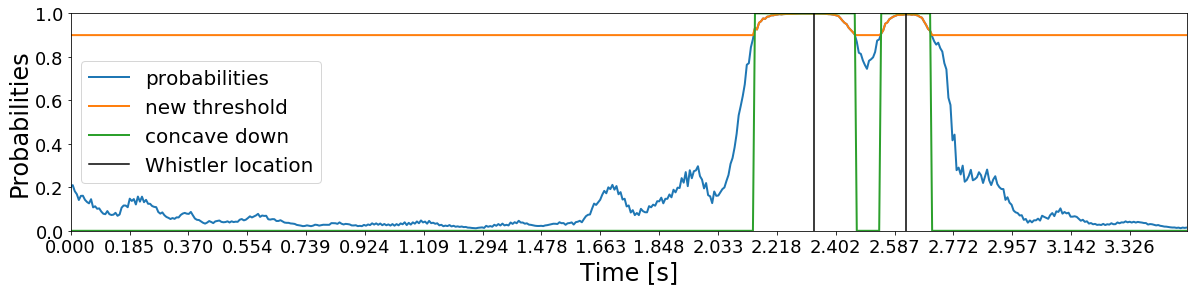

[['2.334' '0.999']
 ['2.622' '0.996']]


In [61]:
thresh = 0.9
pulses = nn.detection_pulse(file, probs=probs, thresh=thresh, concav=False, concav_window=0,concav_error=-0.0)
locations = nn.detection_starting_locations(file, probs=probs, thresh=thresh, concav=False, concav_window=0,concav_error=-0.0)
concav_window=0.05
new_thresh = np.array([p if p>=t else t for p,t in zip(probs,np.full(len(probs),thresh))])
sample = Sample(dataset_loc, site, file)
sample.spectrogram_with_axis()
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)

plt.figure(figsize=(sample.get_figsize()[0],4))
plt.plot(list(range(len(probs))*sample.get_time_res()),probs, linewidth=font[-1])
plt.plot(list(range(len(probs))*sample.get_time_res()),new_thresh, linewidth=font[-1])
plt.plot(list(range(len(probs))*sample.get_time_res()),pulses, linewidth=font[-1])
legend = ['probabilities', 'new threshold', 'concave down']
for l in locations:
    plt.axvline(eval(l[0]), color='black')
legend.append('Whistler location')
plt.xticks(np.linspace(0,len(probs),20)*sample.get_time_res())
plt.autoscale(tight=True)
plt.legend(legend,fontsize=font[1], loc=None)
plt.xlabel('Time [s]',fontsize=font[2])
plt.ylabel('Probabilities',fontsize=font[2])
plt.xticks(fontsize=font[3])
plt.yticks(fontsize=font[3])
plt.show()
print(locations)

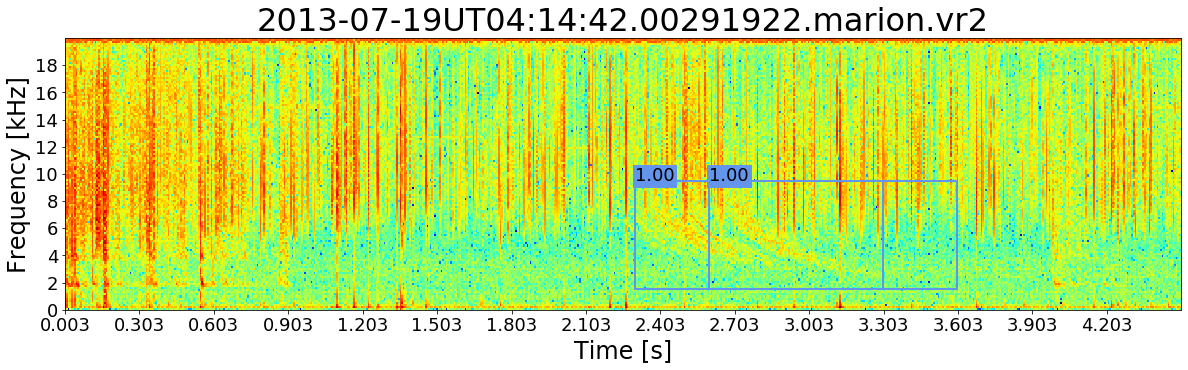

In [66]:
bboxes = nn.detection_bounding_boxes(file, probs=probs, thresh=thresh, concav=False, concav_window=0,concav_error=-0.0, time_error=1)
sample = Sample(dataset_loc, site, file)
freq_size = 4
sample.spectrogram_with_axis(log10=True)
sample.set_figsize(freq_size*sample.get_time_freq_ratio(dec=0), freq_size)
# sample.apply_transform(transforms, transforms_params)
sample.spectrogram_plot(figsize=(sample.get_figsize()[0],5) , xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                               xaxis=True, yaxis=True,ticks=[0.3,2], title=sample.get_file(), cmap='jet', cmap_show=False, font=font,output=bboxes)